# Bank Marketing Analysis

by Casey Durfee <casey.durfee@colorado.edu>

code available at: https://github.com/csdurfee/bank-marketing

I took a look at the "Bank Marketing" dataset in the  UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#.

The data covers a bank's outbound marketing efforts to over 40,000 customers, with some information about them and the state of the economy at the time they were contacted, and whether they bought the product (a term deposit account) or not.  There are 20 features for each customer. I will go through each of the 20 features below and describe what they are, and what the data looks like.

My goal will be to build a Machine Learning model to predict who is likely to buy. I will look at a few of the algorithms covered in this class (random forest, SVM, gradient boosting) and determine which one does the best job of making predictions on this dataset. I will then optimize whichever algorithm shows the best results using grid search. Part of my criteria here is which algorithms can actually run in a timely fashion on my machine, so I will be looking for ways to optimize.

My motivation is that a good model could help the bank spend its sales and marketing budget more effectively and be used to predict the success of using outbound marketing to promote new products.

The original research paper is available online here: https://www.sciencedirect.com/science/article/pii/S016792361400061X#t0010

Citations.

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

[UCI, 2022] UCI Machine Learning Repository: Bank Marketing Data Set. (n.d.). Retrieved May 23, 2022, from https://archive.ics.uci.edu/ml/datasets/Bank+Marketing# 

### Running this notebook for yourself

To run this code locally, you will need to install the required libraries. If you don't want to junk up your global dependencies, you can use virtualenv.

1. download this repo
2. go to the downloaded directory
3. `virtualenv venv`
4. `source venv/bin/activate`
5. `pip install -r requirements.txt`
6. go make a cup of coffee

### Importing the necessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.preprocessing import StandardScaler

In [2]:
## if true, this will automatically download & cache the data.
USE_CACHE = True

if USE_CACHE:
    import requests_cache
    import zipfile
    import io
    session = requests_cache.CachedSession("http_cache", 
                                            backend="filesystem")
    zipped = session.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip")
    z = zipfile.ZipFile(io.BytesIO(zipped.content))
    raw_data = z.open("bank-additional/bank-additional-full.csv")
    bank_data = pd.read_csv(raw_data, delimiter=";")

else:
    ## file obtained from https://archive.ics.uci.edu/ml/machine-learning-databases/00222/
    # you will need to manually download & extract bank-additional.zip in this dir
    bank_data = pd.read_csv("bank-additional-full.csv", delimiter=";")

bank_data.sample()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
2545,35,admin.,single,university.degree,no,yes,yes,telephone,may,tue,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no


## Initial Data Exploration & Cleaning

It's always good to start by checking whether any of the columns have null values. They don't.

In [3]:
for col in bank_data.columns:
    if bank_data[col].isnull().any():
        print(f"Nulls in {bank_data[col]}")

### Categorical Variables

Next, let's check the categorical variables, such as `job`, `marital`, `education`, `default`, `housing`, `loan`, and `contact`:

In [4]:
for col in bank_data.columns:
    if bank_data[col].dtype == 'object':
        print(bank_data[col].value_counts())
        print("\n")

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64


married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64


university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64


no         32588
unknown     8597
yes            3
Name: default, dtype: int64


yes        21576
no         18622
unknown      990
Name: housing, dtype: int64


no         33950
yes         6248
unknown      990
Name: loan, dtype: int64


cellular     26144
telephone    15044
Name: contact, dtype: int64


may    13769
jul     717

#### Unknown Values in Categorical Variables

Many of the categorical variables about the customer's demographics have 'unknown' values: `job`, `marital`, `education`, `default`, `housing`, `loan`. (for reference, `default` is whether the customer is in default on any loans. `housing` is whether the customer has a mortgage with the bank. `loan` is whether the customer has a non-housing loan.)

While unknown values are not ideal, I don't believe it makes sense to throw out these values. If it turns that customers with `unknown` values are less likely to buy the product, that says something too: that the business should stop trying to market to customers that they don't have enough demographic information about. In other words, `unknown` conveys less information than the other categorical values, but not zero information.

#### Are the Categorical Variables Reasonable?

`poutcome` is whether previous marketing campaigns to this person were successful. It looks like this is a very strong predictor of whether this campaign will be successful, so it will be interesting to see if this is used by the winning model.

In [5]:
bank_data.poutcome.value_counts()

success_and_yes = len(bank_data[ (bank_data.poutcome == 'success') & (bank_data.y == 'yes')])
success_and_no = len(bank_data[ (bank_data.poutcome == 'success') & (bank_data.y == 'no')])

poutcome_rate = success_and_yes / (success_and_yes + success_and_no)

overall_rate = len(bank_data[bank_data.y == 'yes']) / len(bank_data)

print(f"success rate for customers who have been previously " + \
      f"marketed to successfully: {100 * poutcome_rate} %")

print(f"lift is {poutcome_rate / overall_rate}")

success rate for customers who have been previously marketed to successfully: 65.1128914785142 %
lift is 5.7798917547781095


That's a big lift. Customers who have responded 'yes' to other direct marketing campaigns are 5.8 times more likely to respond yes to this one.

Other than that, this field is just a yes/no value, so there are no outliers to look at, and without domain knowledge, it's hard to draw any conclusions about whether there are bad datapoints.

#### Date fields

`month` and `day_of_week` indicate when the customer was contacted.

Note that for `month` and `day_of_week` it doesn't make sense to convert them to numbers. 'February' isn't January +1 within the context of this model (there's no reason to believe that jan < feb < mar < ... as far as success rate). So we should treat them as categorical variables even though they do have a 'natural' numerical equivalent.

Because this data is over an irregular span of time, the days of the week are evenly distributed, but the months are not. Over a third of the calls are from the month of May. I believe this strongly limits the value of this info, and in the real world, turning time series data into categorical variables like this would be a bad idea.

0.3342963970088375

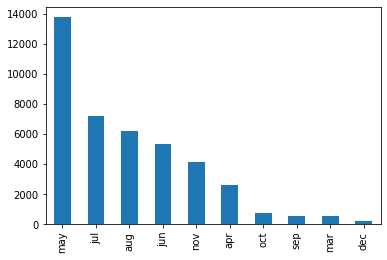

In [6]:
bank_data['month'].value_counts().plot.bar()

len(bank_data[bank_data.month == 'may']) / len(bank_data)

#### `y` and class imbalance

`y` is whether the sales attempt was successful or not. Converting `y` is easy:

In [7]:
bank_data['y'] = bank_data['y'].replace({'no': 0, 'yes': 1})

About 90% of sales calls are unsuccessful. That's a pretty big class imbalance, which means we need to be careful with how we select and score our model, because a model that always predicts `no`, regardless of the feature data, would be accurate 89% of the time:

In [8]:
print(100 * sum(bank_data.y == "no") / len(bank_data.y))

0.0


sklearn's `DummyClassifier` always predicts the majority class, so we'll use it as a baseline comparison to keep us honest when comparing models.

#### Converting Categoricals to Dummy Variables

If a categorical variable has `n` possible values, only `n-1` dummy variables are needed to encode the information, since the last category can be inferred from the value of the other categories.

So I am converting each categorical variable to dummy variables, then dropping the least frequent dummy variable. `get_dummies` has an option to drop the first dummy variable, but I think dropping the least frequent makes the model marginally more understandable, because on most of these variables, "unknown" is the least frequent option.

In [9]:
for field in bank_data.columns:
    if bank_data[field].dtype == 'object':
        dummies = pd.get_dummies(bank_data[field], prefix=field)
        toss_variable = f"{field}_{bank_data[field].value_counts().idxmin()}"

        bank_data = pd.concat([bank_data, dummies], axis='columns') \
                        .drop([field, toss_variable], axis='columns')

### Numerical values

Now, let's look at the rest of the non-categorical values. We mostly get numerical data about previous contacts with the customer, and about the economy at the time of contact. The original paper analyzed more demographic data, such as the customer's net worth, but here we are only given age. The range and distribution look reasonable:

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64


<AxesSubplot:>

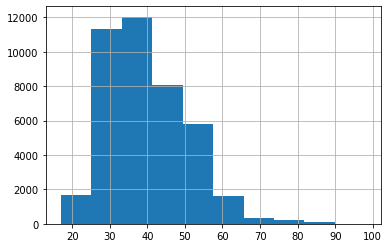

In [10]:
print(bank_data.age.describe())

bank_data.age.hist()

#### Previous Contacts Data

We are given several fields about previous contacts with the customer.

`pdays` is the number of days since last contact, and if there hasn't been a previous contact, the value 999 is assigned. It looks like this is the most common value in the column, indicating most people haven't been contacted before.

The column `previous` indicates the number of previous contacts with the customer. This column should always be 0 if `pdays` is 999. Let's make sure that's true.

In [11]:
possibly_bad_pdays = bank_data[(bank_data.pdays == 999) & (bank_data.previous > 0) ]

print("possibly bad 'pday' values: %.2f %%" % (100 * len(possibly_bad_pdays.previous) / len(bank_data)))

possibly bad 'pday' values: 9.98 %


Oh no! Almost 10% of the rows have a value that we know has to be wrong. So I'm going to to toss `pdays`.

The documentation cautions that the  `duration` column is not a realistic column to use for a predicative model, so it's gone as well:

> this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Despite the caution, they used this field in their analysis, and unsurprisingly, it was one of the strongest predictors they found! On top of that, 4 of the top 5 strongest predictors they found were not included in the public dataset, presumably for privacy or proprietary reasons. So I won't be able to compare my models to theirs, because I don't have the same data they did, and are trying to make predictions rather than post-hoc explanations.

In [12]:
bank_data = bank_data.drop(['pdays', 'duration'], axis=1)

`campaign` is the "number of contacts performed during this campaign and for this client (numeric, includes last contact)". It has an extremely long tail, which is unusual, and worth checking out:

count    41188.000000
mean         2.567593
std          2.770014
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64


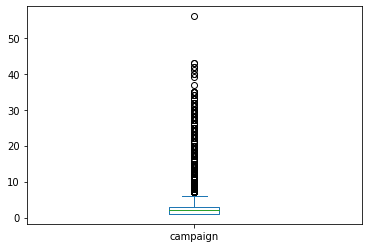

In [13]:
bank_data.campaign.plot.box()

print(bank_data.campaign.describe())

The largest value is 56 times. That seems like a huge number of contacts to one person before they finally said "yes" or "no". Does the distribution of this data make sense?

Intuitively, it seems like `campaign` should follow an exponential distribution. We can use a qq plot to verify this. Does this field act like a prototypical exponential distribution?

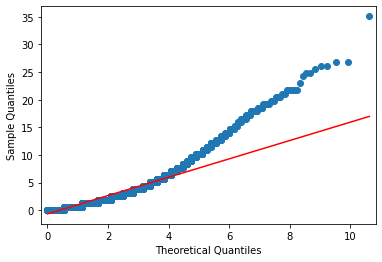

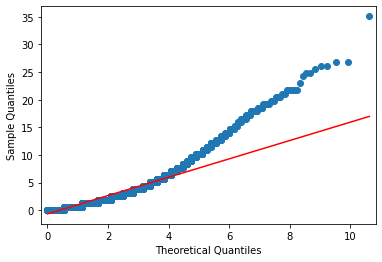

In [14]:
sm.qqplot(bank_data.campaign, fit=True, line='r', dist=stats.expon)

Ideally, we'd like to see a flat line there. So it doesn't (based on the eye test, at least) appear to be an exponential distribution, because the tail is too long, but it's close.  The `gamma` distribution fits better, since it's just a more generalized version of the exponential.

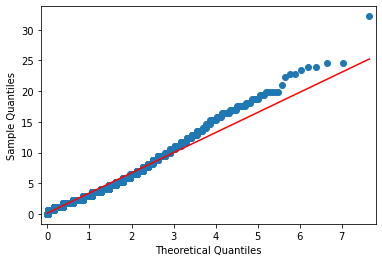

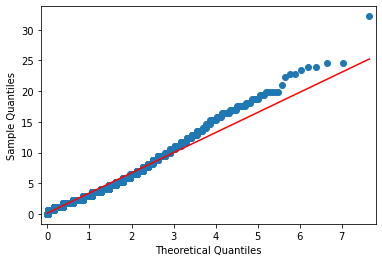

In [15]:
sm.qqplot(bank_data.campaign, fit=True, line='r',dist=stats.gamma)

This looks like a pretty good fit, so for now I'm going to assume that the data in the `campaign` field is organic, rather than being due to some type of error. I think it would be justified to remove the one extreme outlier (in the top right of the chart above) because it clearly diverges from the other 41,000 data points. But it's also unlikely to have a major impact given the number of samples and other features in the model.

### Economic Factors Data

The remaining variables are all macroeconomic statistics at the time the customer was contacted: `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m` and `nr.employed`.

We need to check correlations between them. Although we've been given 5 metrics here, are we really getting 5 unique dimensions of data, or can we eliminate some?

In [16]:
macro_predictors = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                    'euribor3m', 'nr.employed']

bank_data.loc[:, macro_predictors].corr()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
emp.var.rate,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,0.906970,0.522034,0.100513,0.945154,1.000000


`emp.var.rate`, `euribor3m` and `nr.employed` are very highly correlated. This is a bit surprising since `euribor3m` is the European inter-bank lending rate, `emp.var.rate` is the employment rate, and `nr.employed` is the number of employees. 

The strong correlation between lending rate and employment rate is curious, but may be explained by the time that this data came from, which was May 2008 to November 2010. That was around the period of the global economic crisis at the end of 2008, which makes me question how valuable this economic data is for predictions in the future. 

Since the correlations are so high, I am only going to use the `euribor3m` rate. I will also keep `cons.price.idx` (consumer price index) and `cons.conf.idx` (consumer confidence index), since they are less correlated, so can potentially add additional value to being in the model.

In [17]:
bank_data = bank_data.drop(['emp.var.rate', 'nr.employed'], axis=1)

Most of these categorical variables don't have a natural order to them, so they need to be encoded as dummy variables. For example, for the `marriage` field, instead of arbitrarily assigning integer values to `{single, married, divorced, unknown}`, I'm adding variables like `{is_single, is_married, is_divorced, is_unknown}` that will be 1 or 0.

### Train-test split

In [18]:
y = bank_data['y'].copy()
x = bank_data.copy().drop(['y'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

print(len(x))

41188


## First Model: Random Forest


A random forest classifier seems like a good first option, since it doesn't require normalization.

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0, class_weight='balanced')
rf_model.fit(x_train, y_train)

print(f"Random Forest accuracy: {rf_model.score(x_train, y_train)}")

Random Forest accuracy: 0.9946585735963581


The random forest classifier looks pretty good. 99.4% accurate on the training set. 

However, it's not significantly better than a dummy classifier as far as accuracy on the test set. This illustrates how accuracy isn't the right metric to use when the classes are imbalanced. Based on accuracy alone, there's no real difference in the two models, even though, if nothing else, the random forest model is clearly doing a lot more work.

In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

dummy_model = DummyClassifier().fit(x_train, y_train)
dummy_pred = dummy_model.predict(x_test)

rf_pred = rf_model.predict(x_test)

print(f"Random Forest Model accuracy: {rf_model.score(x_test, y_test)}")
#print(classification_report(y_test, rf_pred))


print(f"Dummy Model accuracy: {dummy_model.score(x_test, y_test)}")
#print(classification_report(y_test, dummy_pred))

Random Forest Model accuracy: 0.8930565671279437
Dummy Model accuracy: 0.8934207331876669


#### ROC AUC - Why?

ROC is essentially a plot of the ratio of true positive rate to false positive rate. It can show us what accuracy does not.

Since the dummy classifier always says yes, the True Positive Rate and False Positive Rate are both 1 (the dummy classifier is a very upbeat classifier). So the AUC will always be .5 for the dummy classifier -- it's the triangle defined by $\{(0,0), (1,1), (1,0)\}$.

So any model that's better at producing true positives than false positives will have an AUC over .5, with the perfect classifier having an AUC of 1.

Instead of accuracy, for the rest of this notebook, I will use the AUC of the ROC curve, which is a much better measure of how relatively good two models are. (This was also the approach of the authors of the original paper.)

Let's calculate the ROC AUC for Random Forest:

In [21]:
fpr, tpr, _ = roc_curve(y_test, rf_pred)
roc_auc = roc_auc_score(y_test, rf_pred)

print(roc_auc)

0.6181599423095968


Well, it beats the dummy model's score of .5. But surely we can do better?

## Second Model: Gradient Boosting

Gradient Boosting is fast and often performs extremely well, without the need for scaling.

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier()
gb_model.fit(x_train, y_train)

GradientBoostingClassifier()

In [23]:
gb_pred = gb_model.predict(x_test)

print(f"Gradient Boosting ROC AUC: {roc_auc_score(y_test, gb_pred)}")

Gradient Boosting ROC AUC: 0.6112859946023571


So, basically equal to random forest. I manually tweaked the parameters, but couldn't do better than .62 with this algorithm.

## Third Model: Neural Networks.

The original paper found a Neural Network model performed the best (though as discussed, they had more/better data than what is in the public dataset; additionally, they were using different machine learning libraries.)

In [24]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier()
nn_scaler = StandardScaler().fit(x_train)
nn_model.fit(nn_scaler.transform(x_train), y_train)

/Users/caseydurfee/msds/machine learning/final-project/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [25]:
nn_pred = nn_model.predict(nn_scaler.transform(x_test))

print(f"Neural Network ROC AUC {roc_auc_score(y_test, nn_pred)}")

Neural Network ROC AUC 0.616048083589185


This did basically the same random forest and gradient boosting, with a slower training time for the model. There's some possible parameter tweaking, but I'm going to save the optimizations for the last model, SVM.


## Final Model: SVM
For SVM, it's super important to keep training data as small as possible because training time can be prohibitive. Because we have an imbalance of 'yes' and 'no' responses, if we're just training on a sample of the data, we want to make sure it includes as many of the rarer 'yes' responses as possible.

sklearn's SVC class does have an option that's supposed to help with class imbalances (`class_weight='balanced'`), but I found it's extremely slow to train on all 40,000 points in this data set (around an hour on my computer.)

I was curious if creating a set of data that contains all the 'yes' responses plus an even amount of 'no' responses that were randomly picked would do better than the `class_weight=balanced` option.

This is just a naive approach. There are algorithms like [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) that surely do a better job, but I wanted to get a feel for it myself.

In [26]:
from sklearn.svm import SVC

"""THE BIG IDEA: get ALL yeses in the x_train set
then a matching number of nos in the x_train set
SO all data is coming from x_train
but we are only using a subsample of it with even class membership.

Since the model hasn't seen anything in x_test & y_test,
we can use that to score without "cheating".
"""

bank_data_in_xtrain = bank_data.iloc[bank_data.index.isin(x_train.index)]

yeses_in_xtrain = bank_data_in_xtrain[bank_data_in_xtrain.y == 1]
nos_in_xtrain   = bank_data_in_xtrain[bank_data_in_xtrain.y == 0]

even_sample_of_nos = nos_in_xtrain.sample(n=len(yeses_in_xtrain))

even_data_svm = pd.concat([yeses_in_xtrain, even_sample_of_nos], 
                    axis='rows')

# shuffle these, so we have the option to take a slice of the data & have it be random
## (roughly equal yes & no)
## taken from https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
even_data_svm = even_data_svm.sample(frac=1).reset_index(drop=True)

print(f"Length of even SVM training data: {len(even_data_svm)}")

even_y_train  = even_data_svm['y'].copy()
even_x_train  = even_data_svm.copy().drop(['y'], axis=1)

print(f"value counts in SVM training data:\n{even_y_train.value_counts()}")

even_scaler = StandardScaler().fit(even_x_train)

scaled_even_x_train = even_scaler.transform(even_x_train)

Length of even SVM training data: 7524
value counts in SVM training data:
0    3762
1    3762
Name: y, dtype: int64


Note we are training the SVM on a special set of data that has an equal number of yes and no datapoints. However, we are then evaluating it against the same `x_test` sample as the other models, so it's fair to compare the outputs of this models to the others we built.

Also note: it's very important to fit the `StandardScaler()` on the same exact train data as the model. If the scaler is fit on data that includes the test data, it's cheating in the sense that the scaler knows about outliers that are not in the training set. So I've tried to be careful here.

In [27]:
svc_model = SVC().fit(scaled_even_x_train, even_y_train)

even_x_test = even_scaler.transform(x_test)
svc_pred = svc_model.predict(even_x_test)
print(f"even inputs SVC ROC score: {roc_auc_score(y_test, svc_pred)}")

even inputs SVC ROC score: 0.7397022320986432


So far, this is the best model we've found as far as ROC, and we haven't even tuned the hyperparameters. And it only took 14 seconds to `fit()` and `predict()` on my computer. 

Let's compare this to using the `class_weight='balanced'` feature of SVC and the same training set we used for the Random Forest model. This will take much longer to run, since we are training on around 35,000 points instead of 8,000. On my computer, it takes about 3 minutes.

In [38]:
RUN_THIS_SLOW_THING = True

if RUN_THIS_SLOW_THING:
    balanced_scaler = StandardScaler().fit(x_train)
    scaled_x_train = balanced_scaler.transform(x_train)

    svc_balanced_class_weight = SVC(class_weight='balanced').fit(scaled_x_train, y_train)

Because the resulting model is more complex, it takes much longer to predict and score as well.

In [39]:
if RUN_THIS_SLOW_THING:
    svc_class_weight_pred = svc_balanced_class_weight.predict(balanced_scaler.transform(x_test))
    print(f"balanced SVC model ROC score: {roc_auc_score(y_test, svc_class_weight_pred)}")

balanced SVC model ROC score: 0.7340452300188176


When I ran it, the model using the `class_weight='balanced'` got a score of .736, which was just slightly worse than training with the even inputs (.738). Since the even inputs are vastly faster to train on, that's what I will use to tune the SVC hyperparameters.

I think I've shown here that the `class_weight='balanced'` is really just a convenience function. it's probably fine for smaller datasets, but for larger datasets, it's very inefficient.

### Using Grid Search to Optimize SVC

So far, SVC has proven to be the best. Let's see how good we can get it with a little grid search to optimize hyperparameters. For the sake of speed, I am only going to train on 1,000 data points from the `even` test sample.  I shuffled this data, so a slice of 1000 should have roughly even `yes` and `no` datapoints. I will reuse the code we were given in Lab 6 to visualize the results of the grid search.

I started with ranges of 2**-5 to 2**5 for both and then kept adjusting them until the values started going down again.

Training with the subset is vastly faster than with the 8,000 data points in the `scaled_even_x_train` set. Training with the entire `x_train` set is not feasible with grid search (at least on my 7 year old laptop.)

Note that we need to make a custom scorer function for it to use the ROC AUC score.

In [30]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer

roc_auc_scorer = make_scorer(roc_auc_score)

parameters = {
    'C': [2**x for x in range(1, 11)],
    'gamma': [2**x for x in range(-14,-4)]
}


# train on just 1000 points -- makes search vastly faster.
grid = GridSearchCV(SVC(), parameters, scoring=roc_auc_scorer) \
            .fit(scaled_even_x_train[-1000:], even_y_train[-1000:])

We can use the code from the week 6 problem set (slightly adjusted) to display the results.

In [31]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.6))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()

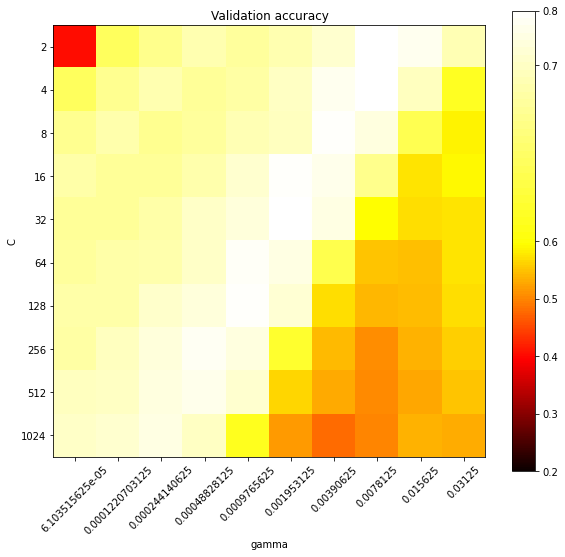

[[0.50836753 0.68905015 0.70085077 0.71017916 0.70495446 0.71022921
  0.71781603 0.73026724 0.72650385 0.71139025]
 [0.68905015 0.70194175 0.71023922 0.70404364 0.70731658 0.71526374
  0.72650385 0.73038735 0.71418276 0.67346612]
 [0.7020018  0.70926834 0.70204184 0.70543489 0.71150035 0.71412271
  0.73008708 0.72274047 0.68602742 0.65981383]
 [0.70829747 0.70410369 0.70440396 0.70949855 0.71793614 0.72917626
  0.72547293 0.70065059 0.65350816 0.66181563]
 [0.70410369 0.70440396 0.70852767 0.71617456 0.72176959 0.73111801
  0.7238915  0.66418777 0.65180663 0.65386848]
 [0.70543489 0.70852767 0.70931839 0.71630467 0.72905615 0.72335102
  0.68481633 0.64179762 0.63906516 0.65422881]
 [0.70852767 0.70834751 0.71757582 0.72140927 0.72923631 0.71891703
  0.65211691 0.63603243 0.638885   0.65131618]
 [0.70737664 0.71381243 0.72164948 0.72796517 0.72250025 0.67680913
  0.63737364 0.62013812 0.63409068 0.64543089]
 [0.71393254 0.71521369 0.72232009 0.72517266 0.71794615 0.64908418
  0.63075768

In [32]:

plotSearchGrid(grid)
print(np.array([x for x in grid.cv_results_["mean_test_score"]]).reshape(len(grid.param_grid["C"]), 
                                                                        len(grid.param_grid["gamma"])))

So, it looks like the optimal score was obtained at C=4, gamma=0.0078125. Let's use these params to train a final SVC model on the entire `even` training set.

In [33]:
tuned_model = SVC(C=4, gamma=.0078125).fit(scaled_even_x_train, even_y_train)

even_x_test = even_scaler.transform(x_test)
tuned_pred = tuned_model.predict(even_x_test)
print(f"even inputs SVC ROC score: {roc_auc_score(y_test, tuned_pred)}")

even inputs SVC ROC score: 0.7418820256016637


That's a slight improvement, but nothing to write home about. I think this shows that in this context, the tuning parameters for SVC don't matter that much. I searched thru 10 orders of magnitude for both C and gamma and most of them gave scores around .72. So it seems like we're kind of already getting the most we can out of SVC.

I also played around with other kernels. The `poly` gave roughly the same results as the default `rbf`.

In [34]:
poly_model = SVC(kernel='poly').fit(scaled_even_x_train, even_y_train)

poly_pred = poly_model.predict(even_x_test)
print(f"poly kernel, even inputs SVC ROC score: {roc_auc_score(y_test, poly_pred)}")

poly kernel, even inputs SVC ROC score: 0.7302114798950183


### Feature Importance

With the `rbf` kernel we are using, we can't get the feature importance just by looking at the coefficients of the model like we could with a `linear` kernel. However, sklearn does have a tool called permutation importance we can use. Note: we will use the ROC AUC scorer we made earlier here.

In [35]:
## adapted from https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(svc_model, even_x_test[:200], y_test[:200], scoring=roc_auc_scorer)


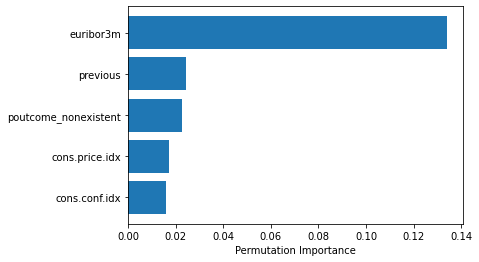

In [36]:
features = np.array(x_train.columns)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx][-5:], perm_importance.importances_mean[sorted_idx][-5:])
plt.xlabel("Permutation Importance")
plt.show()

%matplotlib inline


So, the `euribor3m` rate is the most significant, which is what the original paper also found to be the strongest predictor. `month_oct` being second I think shows the potential for overfitting due to the weird structure of date data (discussed above).

## Evaluating the Models

Let's plot the ROC curve for all the models.

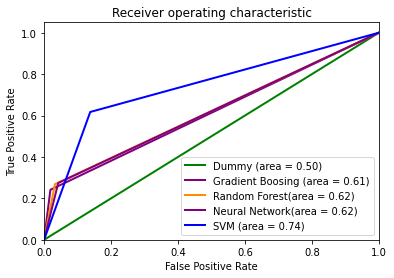

In [37]:

### Plot dummy -- AUC should be .5
lw = 2

fpr, tpr, _ = roc_curve(y_test, dummy_pred)

plt.figure()
roc_auc = roc_auc_score(y_test, dummy_pred)
plt.plot(
    fpr,
    tpr,
    color="green",
    lw=lw,
    label="Dummy (area = %0.2f)" % roc_auc,
)

## BOOSTING
fpr, tpr, _ = roc_curve(y_test, gb_pred)
roc_auc = roc_auc_score(y_test, gb_pred)

plt.plot(
    fpr,
    tpr,
    color="purple",
    lw=lw,
    label="Gradient Boosing (area = %0.2f)" % roc_auc,
)


## Random Forest
fpr, tpr, _ = roc_curve(y_test, rf_pred)
roc_auc = roc_auc_score(y_test, rf_pred)

plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="Random Forest(area = %0.2f)" % roc_auc,
)


## Neural Network
fpr, tpr, _ = roc_curve(y_test, nn_pred)
roc_auc = roc_auc_score(y_test, nn_pred)

plt.plot(
    fpr,
    tpr,
    color="purple",
    lw=lw,
    label="Neural Network(area = %0.2f)" % roc_auc,
)

### SVM
fpr, tpr, _ = roc_curve(y_test, svc_pred)

roc_auc = roc_auc_score(y_test, svc_pred)
plt.plot(
    fpr,
    tpr,
    color="blue",
    lw=lw,
    label="SVM (area = %0.2f)" % roc_auc,
)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# Conclusions
SVM definitely did the best, achieving a much higher true positive rate than the others, at the cost of only a slightly higher false positive rate. Out of the box, there was very little difference between random forest, neural network, and boosting on this problem.

#### What Worked Well
I was able to improve training times of SVM without hurting quality by only working on a subset of the training data with even classes. This performed much, much better than the built-in `balanced` option in the `SVC` class.

#### What Didn't Work
I wasn't able to significantly improve the SVM performance by using a grid search, perhaps because I had to use subsamples to make the grid search run in a timely fashion. However, for all models I tried against this data set, tuning hyperparameters had little impact on the quality of results.

#### Ways To Improve
The biggest potential improvement I see is more analysis of correlations within the categorical variables, and feature reduction in general. This could help the model be faster and more understandable without sacrificing quality of prediction. The initial data had 20 dimensions, and converting to dummy variables blew that up to 50 dimensions.  With 40,000 observations in the dataset, that's over 2 Million points of data total.

It would also be interesting to use the SMOTE library rather than my hand-rolled class balancing. There are a wide variety of techniques for dealing with class imbalance that I didn't have time to get into.